In [53]:
b = .04
p =.7
lista = [(n*b**2)/(p*(1-p)+(n*b**2)) for n in range(101)]

In [57]:
def get_lambda(number_item, b, v):
    return (number_item*b**2)/(v+(number_item*b**2))

In [64]:
import numpy as np
import pickle
import copy
from experiments import *
from utils import *

In [67]:
scenarios = {'cnn':['summarization_cnndm:temperature=0.3,device=cuda,'], 
             'xsum':['summarization_xsum:temperature=0.3,device=cuda,'], 
             'boolq:':['boolq:'],
             'civil_comments':['civil_comments:demographic=LGBTQ,',
                               'civil_comments:demographic=all,',
                               'civil_comments:demographic=black,',
                               'civil_comments:demographic=christian,',
                               'civil_comments:demographic=female,',
                               'civil_comments:demographic=male,',
                               'civil_comments:demographic=muslim,',
                               'civil_comments:demographic=other_religions,',
                               'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             'narrative_qa:':['narrative_qa:'],
             'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            
scenarios_metrics = {'boolq:':'em', 
                     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':'em',
                     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':'em',
                     'imdb:':'em', 
                     'mmlu':'em', 
                     'msmarco:track=regular,valid_topk=30,':'RR@10', 
                     'msmarco:track=trec,valid_topk=30,':'NDCG@10', 
                     'narrative_qa:':'f1', 
                     'natural_qa:mode=closedbook,':'f1', 
                     'natural_qa:mode=openbook_longans,':'f1', 
                     'quac:':'f1', 
                     'raft':'em', 
                     'truthful_qa:task=mc_single,method=multiple_choice_joint,':'em'}

In [70]:
with open('data/helm.pickle', 'rb') as handle:
    data = pickle.load(handle)
device = 'cuda'
iterations = 10
Ds = [5, 10, 15, 20, 25] #

num_elements = 4
set_of_rows = [[0,1,2,3], #ai21
               [5,6,7,8,9,10,11], #cohere
               [4,12,13], #anthropic+microsoft
               [14,15,16,17,18,19,20,21,22], #openai
               [23,24,25,26,27]] #together
set_of_rows

[[0, 1, 2, 3],
 [5, 6, 7, 8, 9, 10, 11],
 [4, 12, 13],
 [14, 15, 16, 17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27]]

In [71]:
scenario_name = 'full' #we are evaluating all scenarios at once
chosen_scenarios = list(scenarios.keys())

In [95]:
bench ='irt_helm'
lambds = [None] + np.round(np.linspace(0,1,10),2).tolist()  # Lambda values to consider
number_items = [10, 25, 50, 75, 100]  # Number of items to consider in evaluations

#cpu = mp.cpu_count()  # Number of available CPU cores
epochs = 2000  # Number of epochs for IRT model training (package default is 2000)
lr = .1  # Learning rate for IRT model training (package default is .1)

accs = {}  # Initialize a dictionary to hold accuracies
results = {}  # Initialize a dictionary to hold results

# Iterate through each set of rows to hide
rows_to_hide =[0, 1, 2, 3]
rows_to_hide_str = ':'.join([str(r) for r in rows_to_hide])

print(f"\nEvaluating models {rows_to_hide}")
        
# Prepare data and scenarios
scenarios_position, subscenarios_position = prepare_data(chosen_scenarios, scenarios, data)
scores = create_responses(chosen_scenarios, scenarios, data)
        
balance_weights = np.ones(scores.shape[1]) #for scenario=='civil_comments', some items need to be downweighted, for other scenarios not
if 'civil_comments' in chosen_scenarios:
    balance_weights[scenarios_position['civil_comments']] = scores[:,scenarios_position['civil_comments']].max(axis=0)
    #(balance_weights==0).sum(axis=0) verifying that no item had weight 0 (the output should be zero)
    scores[:,scenarios_position['civil_comments']] = (scores[:,scenarios_position['civil_comments']]>0).astype(float)

# Create training and test sets by hiding specific rows
scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
responses_train = np.zeros(scores_train.shape)
responses_test = np.zeros(scores_test.shape)

# Threshold responses 
cs = np.linspace(0.01,.99,1000)  # Threshold values to consider
for scenario in chosen_scenarios:
    ind = scenarios_position[scenario]
    # Find the best threshold value that minimizes the difference between mean responses and mean scores
    c = cs[np.argmin([np.mean((np.abs((scores_train[:,ind]>c).mean(axis=1)-scores_train[:,ind].mean(axis=1)))) for c in cs])]
    # Apply the threshold to train and test responses
    responses_train[:,ind] = (scores_train[:,ind]>c).astype(int)
    responses_test[:,ind] = (scores_test[:,ind]>c).astype(int)

# Transforming scores back
scores = balance_weights*scores
scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
#print("shape of scores=",scores.shape, "shape of scores train=",scores_train.shape,"shape of scores test=",scores_test.shape)
        
# Choosing D through validation
val_ind = list(range(int(responses_train.shape[0]/3)))
train_ind = [i for i in range(responses_train.shape[0]) if i not in val_ind]
        
# Create IRT dataset for validation and train IRT models
dataset_name = f'data/{bench}/rows-{rows_to_hide_str}_scenario-{scenario_name}_val.jsonlines'
create_irt_dataset(responses_train[train_ind], dataset_name)

errors = []  # Initialize a list to hold validation errors
errors2 = []
print("\ni) choosing optimal D")
for D in tqdm(Ds):
    # Train IRT model for the current dimension (D)
    model_name = f'models/{bench}/rows-{rows_to_hide_str}_D-{D}_scenario-{scenario_name}_val/'
    #train_irt_model(dataset_name, model_name, D, lr, epochs, device)
    # Load trained IRT model parameters
    A, B, Theta = load_irt_parameters(model_name)
    # Determine seen and unseen items for validation
    seen_items = list(range(0, responses_train.shape[1], 2))
    unseen_items = list(range(1, responses_train.shape[1], 2))
    # Estimate ability parameters for the validation set
    thetas = [estimate_ability_parameters(responses_train[val_ind][j], seen_items, A, B) for j in range(len(val_ind))]

    # Compute validation errors for each scenario and update the errors list (in the end, we give the same weight for all scenarios)
    errors2.append([])
    for scenario in chosen_scenarios:
        ind = [u for u in unseen_items if u in scenarios_position[scenario]]
        errors2[-1].append(np.mean([abs((balance_weights*item_curve(thetas[j], A, B))[0,ind].mean()-scores_train[val_ind][j,ind].mean())for j in range(len(val_ind))]))
    errors.append(np.mean(errors2[-1]))

# Choose the simplest model (D) that is not far from the best model based on validation errors
ind_D = np.argmax(np.array(errors)-np.min(errors)<.0025)
D = Ds[ind_D] 
#D = Ds[np.argmin(errors)] 
print("- opt D=", D, "errors=", errors, "\n")

# Choosing lambdas (For random G-PIRT)
print("\nii) choosing optimal lambdas")
        
iterations_val = 2*iterations
        
if False: seen_items_dic = get_disc_items(responses_train[train_ind], number_items, chosen_scenarios, rows_to_hide_str, scenarios_position, device, bench)
        
opt_lambds = {'random_gpirt': {}, 'anchor_gpirt': {}, 'anchor-irt_gpirt': {}, 'disc_gpirt': {}}  # Initialize a dictionary to hold optimal lambda values
        # Reload trained IRT model parameters for the chosen dimension (D)
model_name = f'models/{bench}/rows-{rows_to_hide_str}_D-{D}_scenario-{scenario_name}_val/'
A, B, Theta = load_irt_parameters(model_name)
print(" - debiasing IRT")
  



Evaluating models [0, 1, 2, 3]

i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [02:12<00:00, 26.44s/it]


- opt D= 5 errors= [0.044579911983804656, 0.0453168327810513, 0.047692893828327226, 0.049759814361327995, 0.05001942216565462] 


ii) choosing optimal lambdas
 - debiasing IRT


In [96]:
def get_lambda(number_item, b, v):
    return (number_item*b**2)/(v+(number_item*b**2))

In [101]:
vs = {}
bs = {}
for i,scenario in enumerate(chosen_scenarios):
    vs[scenario] = np.var(scores_train[:,scenarios_position[scenario]])
    bs[scenario] = np.mean(errors2[ind_D][i]) 
    
lambds = {}
for scenario in chosen_scenarios:
    lambds[scenario] = {}
    for number_item in number_items: 
        lambds[scenario][number_item] = get_lambda(number_item, bs[scenario], vs[scenario])

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 46916.15it/s]


In [102]:
lambds

{'cnn': {10: 0.5505698352323718,
  25: 0.7538521812501997,
  50: 0.8596530418120308,
  75: 0.9018433662154779,
  100: 0.9245305683197678},
 'xsum': {10: 0.10611472364294021,
  25: 0.22885886611138165,
  50: 0.372473800568467,
  75: 0.47099420083697296,
  100: 0.542777283492321},
 'boolq:': {10: 0.09549278534748269,
  25: 0.20882066321582507,
  50: 0.3454948605201695,
  75: 0.4419044351820251,
  100: 0.5135580531115531},
 'civil_comments': {10: 0.03445619767330429,
  25: 0.08190717924487449,
  50: 0.15141258107195896,
  75: 0.21113465042095697,
  100: 0.2630031729043548},
 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {10: 0.2028549402625461,
  25: 0.38882480252358737,
  50: 0.5599335521904084,
  75: 0.6561891636343071,
  100: 0.7178941069690664},
 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {10: 0.038526343227734794,
  25: 0.09105389750791747,
  50: 0.16690998990222974,
  75: 0.23108018885882844,
  100: 0.2860717473439651},

In [54]:
lista[10], lista[25], lista[50], lista[75], lista[100]


(0.07079646017699114,
 0.16,
 0.27586206896551724,
 0.36363636363636365,
 0.43243243243243246)

In [55]:
import matplotlib.pyplot as plt

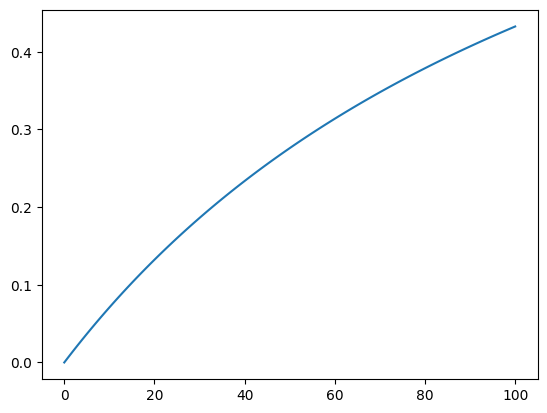

In [56]:
plt.plot(lista)
plt.plot()
plt.show()